3.2 Preparação dos Dados em Formato Tidy

3.2.1 Organização dos Dados

Transformar o dataset limpo para formato tidy data seguindo os princípios fundamentais: cada
variável forma uma coluna, cada observação forma uma linha e cada tipo de unidade observacio-
nal forma uma tabela.

In [1]:
import pandas as pd
import duckdb

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

In [11]:
# nosso dataset ja é tidy, e isso é observável no nosso csv gerado na etapa anterior: cada diferente variável é uma coluna, cada
# registro forma uma linha e todos eles são exsicatas de uma única tabela.
# então nessa seção o que faremos é reduzir o tamanho do nosso acervo - pois ele ainda contém todos os registros que não mais
# consideraremos, pois eles foram desqualificados em alguma das buscas que fizemos (barcode, estado, país, taxonomista)
# e portanto não serão utilizados.
# PS: registros_biodiversidade.csv está copiado para dentro de etapa_3, caso tenha modificado alguma pesquisa por favor sobrescreva
# o arquivo daqui com o seu!

df = pd.read_csv("registros_biodiversidade.csv", encoding="utf-8-sig", dtype=str)

df_filtrado = df[
    df["barcode_att"].notna() &
    df["stateprovince_att"].notna() &
    df["country_att"].notna() &
    df["identifiedby_att"].notna()
]

df_filtrado.to_csv("registros_biodiversidade_filtrado.csv", index=False, encoding="utf-8-sig", quoting=1)

print(f"dataset tidy reduzido salvo com {len(df)} linhas e {len(df.columns)} colunas.")

dataset tidy reduzido salvo com 185617 linhas e 34 colunas.


3.2.2 Reestruturação Necessária



In [2]:
df = pd.read_csv("registros_biodiversidade_filtrado.csv")

print("Dimensões iniciais:", df.shape)
print("Colunas:", list(df.columns))
print("="*50)

# remove colunas
cols_to_drop = ['country_att', 'barcode_att', 'stateprovince_att', 'identifiedby_att']
df = df.drop(columns=cols_to_drop, errors='ignore')
print("Colunas removidas (duplicadas ou redundantes):", cols_to_drop)

# normalização de colunas
if 'occurrenceremarks' in df.columns:
    df['occurrenceremarks'] = (
        df['occurrenceremarks']
        .fillna('')
        .str.replace(r'<.*?>', '', regex=True)
        .str.strip()
    )

# padronização
numeric_cols = ['yearcollected', 'monthcollected', 'daycollected']
for col in numeric_cols:
    if col in df.columns:
        df[col] = df[col].astype('Int64')  # permite NaN

# coordenadas
for col in ['decimallatitude', 'decimallongitude']:
    if col in df.columns:
        df[col] = df[col].astype(float)

# IDs
for col in ['id', 'collectionid']:
    if col in df.columns:
        df[col] = df[col].astype(int)

# data de modificação
if 'modified' in df.columns:
    df['modified'] = pd.to_datetime(df['modified'], errors='coerce')

print("Tipos de dados ajustados com sucesso!")
print("="*50)

# parquet
df.to_parquet("registros_biodiversidade_preparado.parquet", index=False)
print("Arquivo Parquet exportado: registros_biodiversidade_preparado.parquet")



Dimensões iniciais: (20960, 34)
Colunas: ['id', 'barcode', 'collectioncode', 'catalognumber', 'scientificname', 'kingdom', 'family', 'genus', 'yearcollected', 'monthcollected', 'daycollected', 'country', 'stateprovince', 'county', 'locality', 'institutioncode', 'phylum', 'basisofrecord', 'verbatimlatitude', 'verbatimlongitude', 'identifiedby', 'collectionid', 'specificepithet', 'recordedby', 'decimallongitude', 'decimallatitude', 'modified', 'scientificnameauthorship', 'recordnumber', 'occurrenceremarks', 'country_att', 'barcode_att', 'stateprovince_att', 'identifiedby_att']
Colunas removidas (duplicadas ou redundantes): ['country_att', 'barcode_att', 'stateprovince_att', 'identifiedby_att']
Tipos de dados ajustados com sucesso!
Arquivo Parquet exportado: registros_biodiversidade_preparado.parquet


3.3 Consultas SQL Analíticas

In [3]:
con = duckdb.connect()

parquet_path = "registros_biodiversidade_preparado.parquet"

print("Executando consultas analíticas sobre o Parquet...\n")

# Tendência temporal (ano)
q1 = """
SELECT yearcollected AS ano, COUNT(*) AS total_registros
FROM parquet_scan('{}')
WHERE yearcollected IS NOT NULL
GROUP BY yearcollected
ORDER BY ano
""".format(parquet_path)
print("Tendência temporal por ano:")
print(con.execute(q1).df().head(), "\n")

# Top 10 famílias
q2 = """
SELECT family, COUNT(*) AS total_registros
FROM parquet_scan('{}')
GROUP BY family
ORDER BY total_registros DESC
LIMIT 10
""".format(parquet_path)
print("Top 10 famílias mais registradas:")
print(con.execute(q2).df(), "\n")

# Ranking de estados
q3 = """
SELECT 
    stateprovince,
    COUNT(*) AS total_registros,
    RANK() OVER (ORDER BY COUNT(*) DESC) AS ranking
FROM parquet_scan('{}')
GROUP BY stateprovince
ORDER BY ranking
""".format(parquet_path)
print("Ranking de estados por registros:")
print(con.execute(q3).df().head(), "\n")

# CTE com gêneros nas top famílias
q4 = """
WITH top_familias AS (
    SELECT family, COUNT(*) AS total_fam
    FROM parquet_scan('{}')
    GROUP BY family
    ORDER BY total_fam DESC
    LIMIT 5
)
SELECT 
    b.family,
    b.genus,
    COUNT(*) AS total_genus,
    RANK() OVER (PARTITION BY b.family ORDER BY COUNT(*) DESC) AS rank_genus
FROM parquet_scan('{}') b
JOIN top_familias t ON b.family = t.family
GROUP BY b.family, b.genus
ORDER BY b.family, rank_genus
""".format(parquet_path, parquet_path)
print("Gêneros dominantes nas 5 famílias principais:")
print(con.execute(q4).df().head(10), "\n")

# Distribuição mensal (sazonalidade)
q5 = """
SELECT 
    monthcollected AS mes,
    COUNT(*) AS total_registros
FROM parquet_scan('{}')
WHERE monthcollected IS NOT NULL
GROUP BY monthcollected
ORDER BY mes
""".format(parquet_path)
print("Distribuição mensal (sazonalidade):")
print(con.execute(q5).df(), "\n")

# Média de coordenadas por família
q6 = """
SELECT 
    family,
    AVG(decimallatitude) AS media_lat,
    AVG(decimallongitude) AS media_long
FROM parquet_scan('{}')
GROUP BY family
ORDER BY family
""".format(parquet_path)
print("Centro geográfico médio por família:")
print(con.execute(q6).df().head(10), "\n")

print("Consultas executadas com sucesso!")

# Detecção de anos com coletas anômalas
q7 = """
WITH total_por_ano AS (
    SELECT 
        yearcollected,
        COUNT(*) AS total_registros
    FROM parquet_scan('{}')
    WHERE yearcollected IS NOT NULL
    GROUP BY yearcollected
),
media_global AS (
    SELECT AVG(total_registros) AS media_geral FROM total_por_ano
)
SELECT 
    t.yearcollected,
    t.total_registros,
    m.media_geral,
    t.total_registros - m.media_geral AS diferenca
FROM total_por_ano t, media_global m
WHERE t.total_registros > m.media_geral * 1.5
ORDER BY diferenca DESC
""".format(parquet_path)
print("Anos com número de coletas acima da média (anomalias):")
print(con.execute(q7).df().head(10), "\n")

# Correlação espacial (latitude x número de registros)
q8 = """
SELECT 
    ROUND(decimallatitude, 1) AS faixa_latitude,
    COUNT(*) AS total_registros
FROM parquet_scan('{}')
WHERE decimallatitude IS NOT NULL
GROUP BY faixa_latitude
ORDER BY faixa_latitude
""".format(parquet_path)
print("Distribuição de registros por faixa de latitude (correlação espacial):")
print(con.execute(q8).df().head(10), "\n")
con.close()

Executando consultas analíticas sobre o Parquet...

Tendência temporal por ano:
    ano  total_registros
0     0               17
1   200                2
2  1767                1
3  1816                6
4  1825                1 

Top 10 famílias mais registradas:
       family  total_registros
0  Piperaceae            20960 

Ranking de estados por registros:
    stateprovince  total_registros  ranking
0          Paraná             3214        1
1    Minas Gerais             2393        2
2  Rio de Janeiro             1971        3
3        Amazonas             1733        4
4       São Paulo             1694        5 

Gêneros dominantes nas 5 famílias principais:
       family             genus  total_genus  rank_genus
0  Piperaceae             Piper        13937           1
1  Piperaceae         Peperomia         6853           2
2  Piperaceae           Ottonia           62           3
3  Piperaceae           Manekia           47           4
4  Piperaceae       Pothomorphe        

3.4 Análise Exploratória e Teste de Hipóteses

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20960 entries, 0 to 20959
Data columns (total 30 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   id                        20960 non-null  int32         
 1   barcode                   20960 non-null  object        
 2   collectioncode            20960 non-null  object        
 3   catalognumber             20926 non-null  object        
 4   scientificname            20953 non-null  object        
 5   kingdom                   20913 non-null  object        
 6   family                    20960 non-null  object        
 7   genus                     20953 non-null  object        
 8   yearcollected             19684 non-null  Int64         
 9   monthcollected            19484 non-null  Int64         
 10  daycollected              20035 non-null  Int64         
 11  country                   20921 non-null  object        
 12  stateprovince     

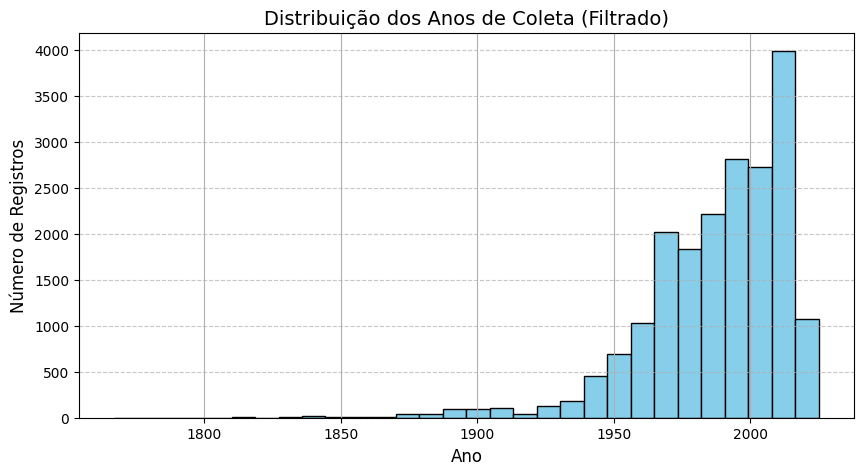

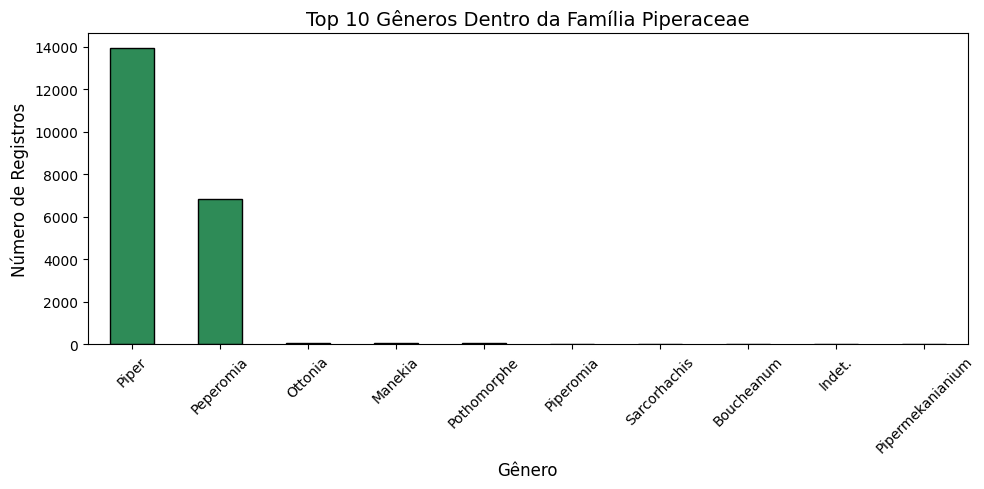

       decimallatitude  decimallongitude
count     20960.000000      20960.000000
mean        -15.842202        -44.528590
std           9.577602         16.745957
min         -59.990000        -93.742500
25%         -23.430000        -51.153181
50%         -19.909722        -47.959444
75%          -8.270000        -42.859402
max          23.000000         69.554100


C:\Users\Dell\AppData\Local\Temp\ipykernel_96468\4166391721.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid['decada'] = (df_valid['yearcollected'] // 10) * 10


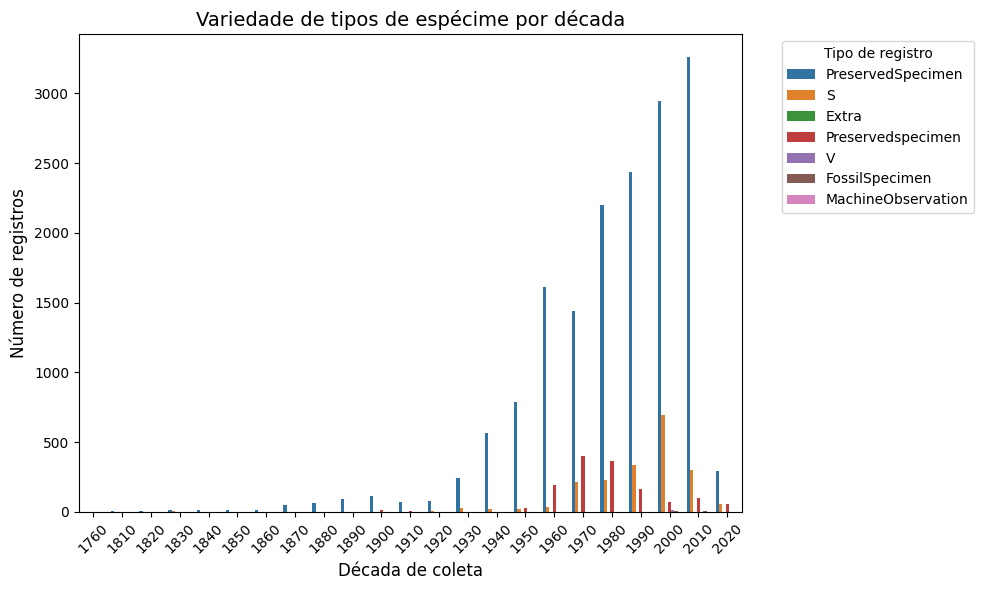

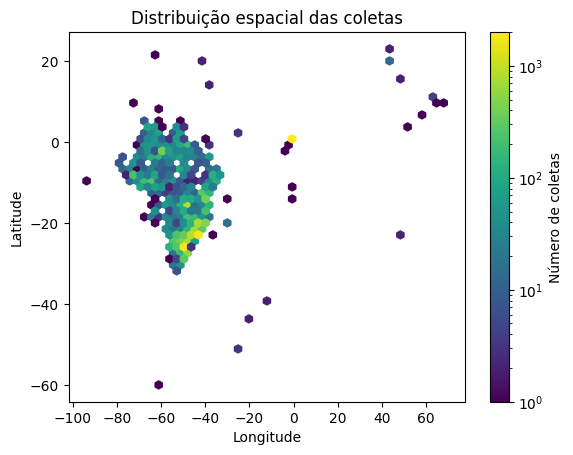

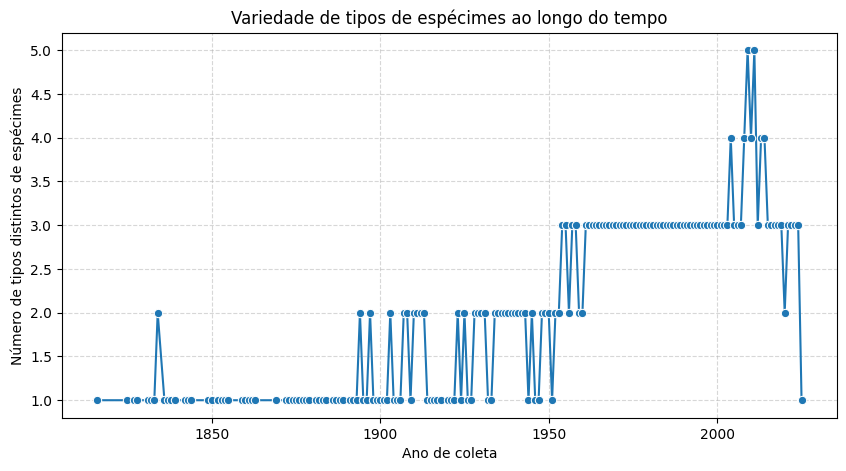

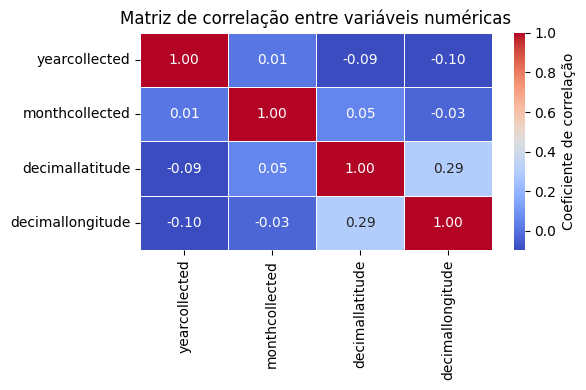

Qui-quadrado: 2262.61, p-valor: 0.00000
Existe associação significativa entre estado e gênero.


In [4]:
df = pd.read_parquet("registros_biodiversidade_preparado.parquet")
print(df.info())

## Análise univariada

# Distribuição temporal das coletas
df_valid = df[(df['yearcollected'] >= 1700) & (df['yearcollected'] <= 2025)]
print(f"Registros removidos por ano inválido: {len(df) - len(df_valid)}")

plt.figure(figsize=(10,5))
df_valid['yearcollected'].hist(bins=30, color='skyblue', edgecolor='black')
plt.title("Distribuição dos Anos de Coleta (Filtrado)", fontsize=14)
plt.xlabel("Ano", fontsize=12)
plt.ylabel("Número de Registros", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


# Distribuição de gêneros dentro da familia Piperaceae
df_piper = df[df['family'] == 'Piperaceae']

top_genus = df_piper['genus'].value_counts().head(10)

plt.figure(figsize=(10,5))
top_genus.plot(kind='bar', color='seagreen', edgecolor='black')
plt.title("Top 10 Gêneros Dentro da Família Piperaceae", fontsize=14)
plt.xlabel("Gênero", fontsize=12)
plt.ylabel("Número de Registros", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Estatísticas descritivas de coordenadas
print(df[['decimallatitude', 'decimallongitude']].describe())

## Anáilise bivariada

# Relação entre ano e tipo de espécime
df_valid['decada'] = (df_valid['yearcollected'] // 10) * 10

plt.figure(figsize=(10,6))
sns.countplot(
    data=df_valid,
    x='decada',
    hue='basisofrecord',
    order=sorted(df_valid['decada'].dropna().unique())
)
plt.title("Variedade de tipos de espécime por década", fontsize=14)
plt.xlabel("Década de coleta", fontsize=12)
plt.ylabel("Número de registros", fontsize=12)
plt.legend(title="Tipo de registro", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Correlação entre latitude e longitude
plt.hexbin(
    df['decimallongitude'],
    df['decimallatitude'],
    gridsize=50,
    cmap='viridis',
    bins='log'
)
plt.colorbar(label='Número de coletas')
plt.title("Distribuição espacial das coletas")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

# Correlação entre coletas recentes e variedade de espécimes
df_valid = df[df['yearcollected'].between(1800, 2025)]

variedade = (
    df_valid.groupby('yearcollected')['basisofrecord']
    .nunique()
    .reset_index()
    .sort_values('yearcollected')
)

plt.figure(figsize=(10,5))
sns.lineplot(data=variedade, x='yearcollected', y='basisofrecord', marker='o')
plt.title("Variedade de tipos de espécimes ao longo do tempo")
plt.xlabel("Ano de coleta")
plt.ylabel("Número de tipos distintos de espécimes")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

## Análise multivariada

# Matriz de correlação para variáveis numéricas
num_cols = ['yearcollected', 'monthcollected', 'decimallatitude', 'decimallongitude']

df_num = df[num_cols].dropna()

corr = df_num.corr(method='pearson')

plt.figure(figsize=(6,4))
sns.heatmap(
    corr,
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    linewidths=0.5,
    cbar_kws={'label': 'Coeficiente de correlação'}
)
plt.title("Matriz de correlação entre variáveis numéricas")
plt.tight_layout()
plt.show()

## Teste de hipóteses

# Relação entre estado e gênero (teste qui-quadrado)
cont_table = pd.crosstab(df['stateprovince'], df['genus'])
chi2, p, dof, ex = chi2_contingency(cont_table)

print(f"Qui-quadrado: {chi2:.2f}, p-valor: {p:.5f}")
if p < 0.05:
    print("Existe associação significativa entre estado e gênero.")
else:
    print("Nenhuma associação significativa encontrada.")